# the version twoof our classifier 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, mean_squared_log_error
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

def perform_neural_network_classification(csv_file_path):
    """
    Performs neural network binary classification on a dataset, calculates
    various classification and regression metrics, generates a confusion
    matrix heatmap, and saves all metrics to an Excel file.

    This version includes an improved model architecture with Batch Normalization
    and an additional hidden layer to prevent overfitting and optimize performance.

    Args:
        csv_file_path (str): The path to the CSV file. All columns except the last
                             are treated as features (X), and the last column,
                             which should contain 0s and 1s, is the target variable (y).
    """
    try:
        # Load the dataset
        df = pd.read_csv(csv_file_path)

        # Separate features (X) and target (y)
        X = df.iloc[:, :-1]  # All columns except the last
        y = df.iloc[:, -1]   # The last column (0 or 1)

        # Split the data into training and testing sets (80/20 split)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Standardize the data to help the neural network converge faster
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # --- Define Callbacks for Training ---
        # EarlyStopping: Stop training when validation loss stops improving for a certain number of epochs.
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True
        )

        # ReduceLROnPlateau: Reduce the learning rate when a metric has stopped improving.
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=20,
            min_lr=0.00001
        )

        # --- Improved Neural Network Model Setup ---
        # Added Batch Normalization and a third hidden layer for a deeper network
        model = Sequential()
        
        # Input layer and first hidden layer with L2 regularization
        model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                        kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization()) # Added Batch Normalization layer
        model.add(Dropout(0.4))
        
        # Second hidden layer
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization()) # Added Batch Normalization layer
        model.add(Dropout(0.3)) # Adjusted dropout rate slightly
        
        # Third hidden layer
        model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization()) # Added Batch Normalization layer

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model with the Adam optimizer and binary cross-entropy loss
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Print the model summary
        print("Model Summary:")
        model.summary()
        
        # Train the model with the added callbacks
        print("\nTraining Neural Network model...")
        history = model.fit(
            X_train_scaled, y_train,
            epochs=2000,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # --- Save the Trained Model ---
        model_path = 'best_model.keras'
        model.save(model_path)
        print(f"\nModel saved successfully to '{model_path}'")

        # --- Make Predictions ---
        y_pred_proba = model.predict(X_test_scaled).flatten()
        y_pred = (y_pred_proba > 0.5).astype("int32")

        # --- 1. Calculate Classification Metrics ---
        print("\n--- Neural Network Model Performance Metrics ---")

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        
        # --- 2. Calculate Regression Metrics on Probabilities ---
        print("\n--- Regression Metrics on Predicted Probabilities ---")

        r2 = r2_score(y_test, y_pred_proba)
        print(f"R-squared (R2): {r2:.4f}")

        mae = mean_absolute_error(y_test, y_pred_proba)
        print(f"Mean Absolute Error (MAE): {mae:.4f}")

        mse = mean_squared_error(y_test, y_pred_proba)
        print(f"Mean Squared Error (MSE): {mse:.4f}")

        rmse = np.sqrt(mse)
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        mape = np.mean(np.abs((y_test - y_pred_proba) / (y_test + 1e-8))) * 100
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

        msle = mean_squared_log_error(y_test + 1e-8, y_pred_proba + 1e-8)
        print(f"Mean Squared Log Error (MSLE): {msle:.4f}")

        # --- 3. Save Metrics to Excel ---
        metrics_data = {
            'Metric': ['Accuracy', 'ROC AUC', 'R2 Score', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MSLE'],
            'Value': [accuracy, roc_auc, r2, mae, mse, rmse, mape, msle]
        }
        
        metrics_df = pd.DataFrame(metrics_data)
        excel_path = 'nn_performance_metrics.xlsx'
        metrics_df.to_excel(excel_path, index=False)
        print(f"\nModel performance metrics saved to '{excel_path}'")

        # --- 4. Generate Confusion Matrix Plot ---
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        
        plot_path = 'confusion_matrix.svg'
        plt.savefig(plot_path, format='svg')
        print(f"\nConfusion matrix plot saved to '{plot_path}'")
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example Usage: Uncomment the line below and provide the path to your CSV file
# if __name__ == "__main__":
#     perform_neural_network_classification("path/to/your/data.csv")


Model Summary:


d:\River-Flood-Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)


Training Neural Network model...
Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5044 - loss: 0.9099 - val_accuracy: 0.5144 - val_loss: 0.8421 - learning_rate: 0.0010
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5130 - loss: 0.8577 - val_accuracy: 0.4944 - val_loss: 0.8391 - learning_rate: 0.0010
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5127 - loss: 0.8463 - val_accuracy: 0.5088 - val_loss: 0.8293 - learning_rate: 0.0010
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5220 - loss: 0.8304 - val_accuracy: 0.5088 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5209 - loss: 0.8180 - val_accuracy: 0.5281 - val_loss: 0.8123 - learning_rate: 0.0010
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5270 - loss: 0.8094 - val_accuracy: 0.5231 - val_loss: 0.8029 - learning_rate: 0.0010
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 

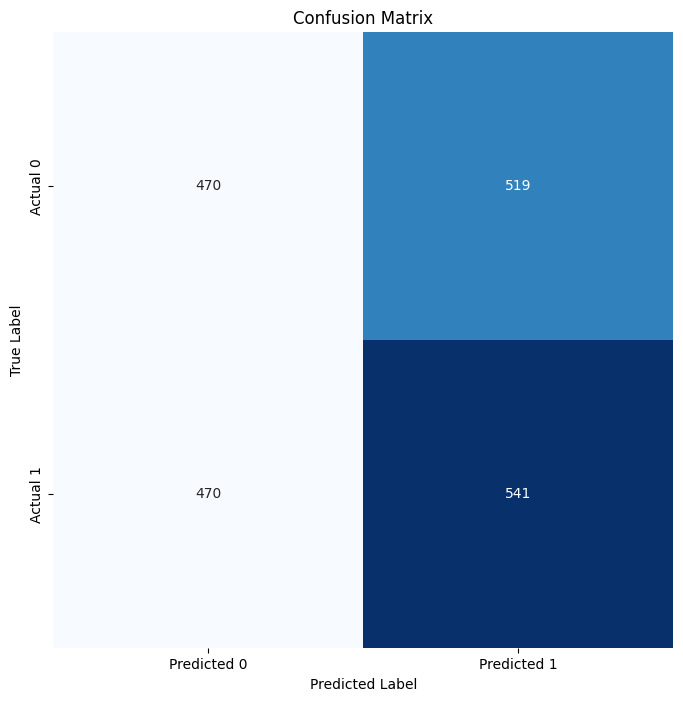

In [2]:
perform_neural_network_classification("../../mapped_dataset_Normalized_version.csv")